In [24]:
# scientific computing libaries
import pandas as pd
import numpy as np

# data mining libaries
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA#, FastICA
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, learning_curve
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

#plot libaries
import plotly
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True) # to show plots in notebook

# online plotly
#from plotly.plotly import plot, iplot
#plotly.tools.set_credentials_file(username='XXXXXXXXXXXXXXX', api_key='XXXXXXXXXXXXXXX')

# offline plotly
from plotly.offline import plot, iplot

# do not show any warnings
import warnings
warnings.filterwarnings('ignore')

SEED = 17 # specify seed for reproducable results
pd.set_option('display.max_columns', None) # prevents abbreviation (with '...') of columns in prints

In [2]:
train = pd.read_csv('train_mice_imputed.csv')
test =pd.read_csv('test_mice_imputed.csv')
submission = pd.read_csv('submission10_xg.csv')

In [6]:
train =train.rename(columns = {'Health.Indicator':'Health_Indicator'})
test = test.rename(columns = {'Health.Indicator':'Health_Indicator'})

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health_Indicator         50882 non-null  object 
 9   Holding_Policy_Duration  50882 non-null  object 
 10  Holding_Policy_Type      50882 non-null  int64  
 11  Reco_Policy_Cat          50882 non-null  int64  
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
dtypes: float64(1), int64(7

In [10]:
c = ['Region_Code','Reco_Policy_Cat']
for col in c:
    train[col]= train[col].astype(object)
    test[col]= test[col].astype(object)

In [13]:
train1 = pd.get_dummies(train,drop_first=True)
test1 = pd.get_dummies(test,drop_first=True)

In [17]:
from imblearn.over_sampling import SMOTE

# Separate input features and target
y = train['Response'] 
X = train1.drop(['ID', 'Response'], axis=1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (35617, 5400)
Number transactions y_train dataset:  (35617,)
Number transactions X_test dataset:  (15265, 5400)
Number transactions y_test dataset:  (15265,)


In [18]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 8457
Before OverSampling, counts of label '0': 27160 

After OverSampling, the shape of train_X: (54320, 5400)
After OverSampling, the shape of train_y: (54320,) 

After OverSampling, counts of label '1': 27160
After OverSampling, counts of label '0': 27160


In [51]:
X_test.shape

(15265, 5400)

In [50]:
test1.shape

(21805, 4556)

In [39]:
# list with only common columns
common_columns = [col for col in X_train_res.columns if col in test1.columns]
# keep only common columns from df1 and df2
X_train_res = X_train_res[common_columns]
test1 = test1[common_columns]

In [52]:
# list with only common columns
common_columns = [col for col in X_test.columns if col in test1.columns]
# keep only common columns from df1 and df2
X_test_res = X_test[common_columns]
test1 = test1[common_columns]

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

parameters = {
    'C': np.linspace(1, 10, 10)
             }
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(X_train_res, y_train_res.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   47.4s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:  2.2min finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=3,
             param_grid={'C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
             verbose=5)

In [54]:
clf.best_params_

{'C': 1.0}

In [55]:
lr1 = LogisticRegression(C=1,penalty='l2', verbose=5)
lr1.fit(X_train_res, y_train_res.ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.1s finished


LogisticRegression(C=1, verbose=5)

In [57]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
y_train_pre = lr1.predict(X_train)

cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)


ValueError: X has 5400 features per sample; expecting 4556

In [ ]:

cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

Recall metric in the testing dataset: 23.081023454157783%


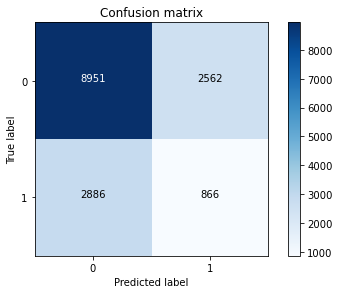

In [27]:
y_pre = lr1.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pre)

print("Recall metric in the testing dataset: {}%".format(100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))
#print("Precision metric in the testing dataset: {}%".format(100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])))
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
plt.show()

In [28]:
tmp = lr1.fit(X_train_res, y_train_res.ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   47.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   47.8s finished


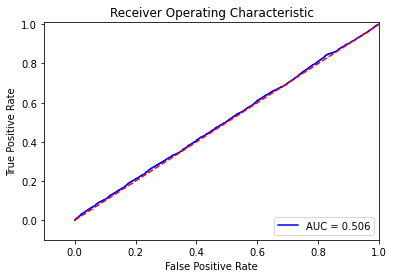

Roc Auc: 0.5064107562101394


In [29]:
y_pred_sample_score = tmp.decision_function(X_test)


fpr, tpr, thresholds = roc_curve(y_test, y_pred_sample_score)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('Roc Auc:',roc_auc)

In [30]:
test1 = test1.drop(['ID'], axis=1)

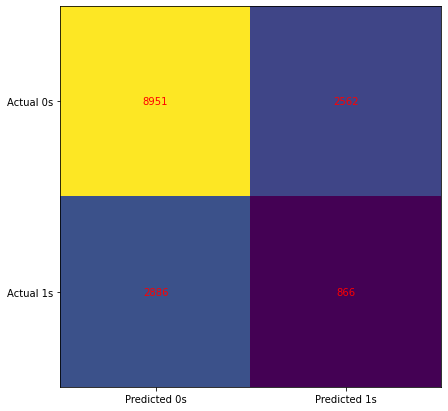

ValueError: X has 4778 features per sample; expecting 5400

In [37]:
final_prediction = lr1.predict_proba(X_test)[:,1]
#Optimal F1 threshold
# Making the Confusion Matrix for threshold as .5
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,  np.where(final_prediction > 0.5, 1, 0))
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

#### Calculate the ROc Curve
fpr, tpr, thresholds = roc_curve(y_test, final_prediction)
auc = metrics.roc_auc_score(y_test, final_prediction)
#plot_roc_curve(fpr,tpr)
thresholds

from sklearn.metrics import f1_score
f1score_ls=[]
for thres in thresholds:
    y_pred = np.where(final_prediction>thres,1,0)
    f1score_ls.append(f1_score(y_test, y_pred))
    
f1score_ls = pd.concat([pd.Series(thresholds), pd.Series(f1score_ls)],axis=1)
f1score_ls.columns = ['thresholds', 'f1score']
f1score_ls.sort_values(by='f1score', ascending=False, inplace=True)
f1score_ls.head()

from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
submission = pd.read_csv('submission16_ensemble.csv')

ensemble_pred_test=pd.DataFrame()
ensemble_pred_test['ID'] = submission['ID']
final_prediction = lr1.predict_proba(test1)[:,1]
ensemble_pred_test['Mean_Response'] = final_prediction
ensemble_pred_test['Response'] = np.where(ensemble_pred_test['Mean_Response']>f1score_ls.iloc[0,0],1,0)
ensemble_pred_test['Response'].value_counts()

submission['Response']= ensemble_pred_test['Response']
submission.to_csv('submission27_lr_optimized.csv', index=False)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test   = train_test_split(X, y, test_size=0.2, random_state=1)

#Scaling
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


import catboost as cb
from sklearn.model_selection import GridSearchCV
params = {'depth': [4, 7, 10],
          'learning_rate' : [0.03, 0.1, 0.15],
         'l2_leaf_reg': [1,4,9],
         'iterations': [300]}
cb1 = cb.CatBoostClassifier()
cb_classifier = GridSearchCV(cb1, params,  cv = 3)
cb_classifier.fit(X_train, y_train)
ytrain_pred = cb_classifier.predict_proba(X_train)
print('Catboost with Grid search cv train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))
ytest_pred = cb_classifier.predict_proba(X_test)
print('Catboost with Grid search cv test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))

# Train Prediction classification report
print(classification_report(y_train, cb_classifier.predict(X_train)))

# Test Prediction classification report
print(classification_report(y_test, cb_classifier.predict(X_test)))

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, cb_classifier.predict(X_test))
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

from sklearn import metrics
def plot_roc_curve(fpr, tpr,model):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    print('AUC:', auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show( )

fpr, tpr, thresholds = roc_curve(y_test,cb_classifier.predict_proba(X_test)[:,1] )
plot_roc_curve(fpr,tpr,cb_classifier)

## LGBM hyper parameter tuning

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test   = train_test_split(X, y, test_size=0.2, random_state=1)

#Scaling
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

import lightgbm as lgb
from sklearn import metrics
lg1 = lgb.LGBMClassifier(silent=False)
param_dist = {"max_depth": [25,50, 75],
              "learning_rate" : [0.01,0.05,0.1],
              "num_leaves": [300,900,1200],
              "n_estimators": [200]
             }
lg = GridSearchCV(lg1, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="roc_auc", verbose=5)
lg.fit(X_train,y_train)

# Train Prediction classification report
print(classification_report(y_train, lg.predict(X_train)))

# Test Prediction classification report
print(classification_report(y_test, lg.predict(X_test)))

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, lg.predict(X_test))
print(cm)

## XGB Hyper parameter tuning

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test   = train_test_split(X, y, test_size=0.2, random_state=1)

#Scaling
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
# Parameter Tuning
xg1 = xgb.XGBClassifier()
param_dist = {"max_depth": [10,30,50],
              "min_child_weight" : [1,3,6],
              "n_estimators": [200],
              "learning_rate": [0.05, 0.1,0.16],}
xg = GridSearchCV(xg1, param_grid=param_dist, cv = 3, 
                                   verbose=10, n_jobs=-1)
xg.fit(X_train, y_train)
#xg.best_estimator_

#model = xgb.XGBClassifier(max_depth=50, min_child_weight=1,  n_estimators=200,\
#                          n_jobs=-1 , verbose=1,learning_rate=0.16)
#model.fit(X_train,y_train)

ytrain_pred = xg.predict_proba(X_train)
print('Extreme GBM with Grid search train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))
ytest_pred = xg.predict_proba(X_test)
print('Extreme GBM with Grid search test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))

# Train Prediction classification report
print(classification_report(y_train, xg.predict(X_train)))

# Test Prediction classification report
print(classification_report(y_test, xg.predict(X_test)))

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, xg.predict(X_test))
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

from sklearn import metrics
def plot_roc_curve(fpr, tpr,model):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    print('AUC:', auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show( )

fpr, tpr, thresholds = roc_curve(y_test,xg.predict_proba(X_test)[:,1] )
plot_roc_curve(fpr,tpr,xg)